In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import time


In [3]:
# Each row is a transaction, and items are in different columns.
df = pd.read_csv('Groceries_dataset.csv')

# For this dataset, we need to group items by transaction based on 'Member_number' and 'Date'
# Let's display the raw data first
print("Raw Data Head:")
print(df.head(10))


Raw Data Head:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
5           4941  14-02-2015        rolls/buns
6           4501  08-05-2015  other vegetables
7           3803  23-12-2015        pot plants
8           2762  20-03-2015        whole milk
9           4119  12-02-2015    tropical fruit


In [4]:
# ### 2. Remove duplicate rows and report before/after dataset dimensions.
print("Dataset dimensions before removing duplicates:", df.shape)
# Remove duplicate rows
df.drop_duplicates(inplace=True)
print("Dataset dimensions after removing duplicates:", df.shape)

Dataset dimensions before removing duplicates: (38765, 3)
Dataset dimensions after removing duplicates: (38006, 3)


In [5]:
# ### 3. Convert transactions into a list-of-lists format.
# Group by transaction and aggregate items into a list
transactions = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index(name='items')
transaction_list = transactions['items'].tolist()

# Display the first 5 transactions in list-of-lists format
print("First 5 transactions (list-of-lists):")
for i, transaction in enumerate(transaction_list[:5]):
    print(f"Transaction {i+1}: {transaction}")


First 5 transactions (list-of-lists):
Transaction 1: ['sausage', 'whole milk', 'semi-finished bread', 'yogurt']
Transaction 2: ['whole milk', 'pastry', 'salty snack']
Transaction 3: ['canned beer', 'misc. beverages']
Transaction 4: ['sausage', 'hygiene articles']
Transaction 5: ['soda', 'pickled vegetables']


In [25]:
# ### 4. Clean item names: lowercase, remove punctuation/whitespace.
# This step ensures that items like "whole milk" and "Whole Milk" are treated as the same item.
cleaned_transactions = []
for transaction in transaction_list:
    cleaned_transaction = [item.strip().lower() for item in transaction]
    cleaned_transactions.append(cleaned_transaction)

print("Example of a cleaned transaction:")
print(cleaned_transactions[0])

Example of a cleaned transaction:
['sausage', 'whole milk', 'semi-finished bread', 'yogurt']


In [26]:
# ### 5. Optionally group rare items (< 2 occurrences) as “Other.”
# This step can help reduce noise in the data.
from collections import Counter
# Flatten the list of lists to count item frequencies
all_items = [item for sublist in cleaned_transactions for item in sublist]
item_counts = Counter(all_items)
# Identify rare items
rare_items = {item for item, count in item_counts.items() if count < 2}
# Group rare items into "Other"
grouped_transactions = []
for transaction in cleaned_transactions:
    new_transaction = [item if item not in rare_items else 'Other' for item in transaction]
    grouped_transactions.append(new_transaction)

print("Example transaction after grouping rare items:")
print(grouped_transactions[0])


Example transaction after grouping rare items:
['sausage', 'whole milk', 'semi-finished bread', 'yogurt']


In [ ]:
#  6. Document your preprocessing pipeline clearly.
# Preprocessing Pipeline Summary:
# 1. Data Loading: The `Groceries_dataset.csv` file was loaded into a pandas DataFrame.
# 2. Duplicate Removal: `drop_duplicates()` was used to remove any identical rows in the dataset.
# 3. Transaction Aggregation: The data was grouped by `Member_number` and `Date` to form individual transactions (baskets). The items in each basket were aggregated into a list.
# 4. Data Cleaning Each item name was converted to lowercase and leading/trailing whitespace was removed to ensure consistency.
# 5. Rare Item Grouping Items appearing less than twice in the entire dataset were grouped into a single category called "Other" to reduce noise.
#
#

C:\Users\Lunatic\AppData\Local\Temp\ipykernel_8116\2547786496.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='item', data=item_freq_df, palette='viridis')


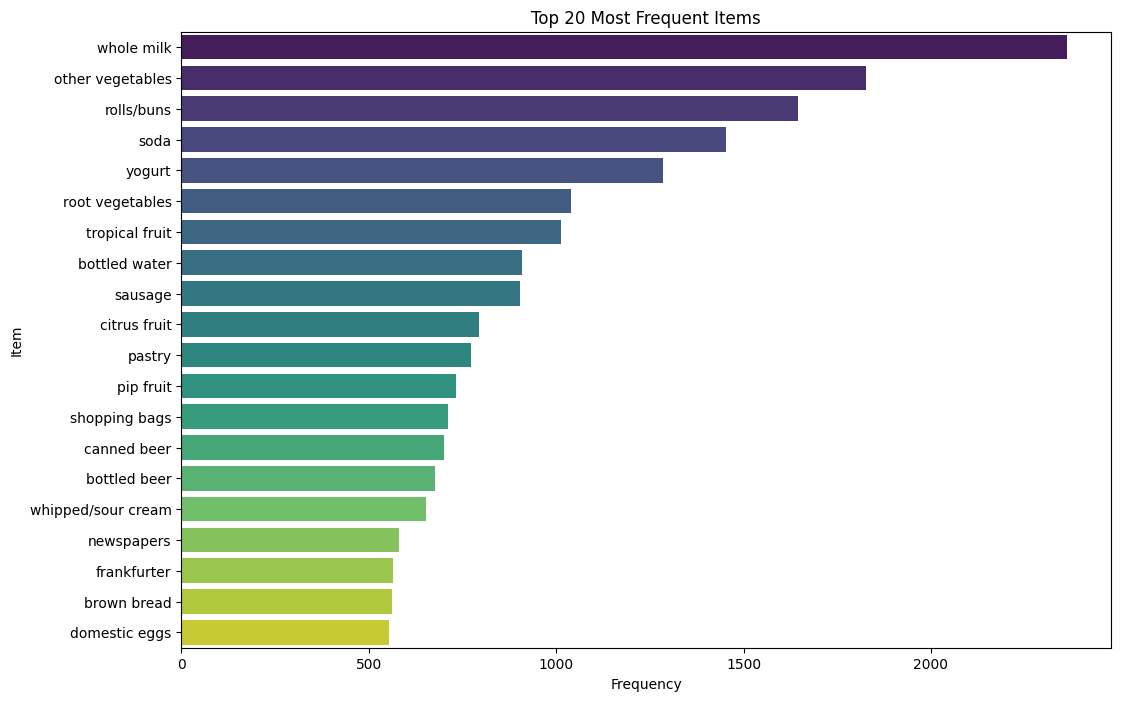

In [9]:
# ## Part B: Exploratory Data Analysis (EDA)
# ### 1. Compute frequency counts of all items; visualize top 20 using a bar chart.
# Re-calculate item counts on the cleaned data
all_items_cleaned = [item for sublist in grouped_transactions for item in sublist]
item_counts_cleaned = Counter(all_items_cleaned)

# Create a DataFrame for visualization
item_freq_df = pd.DataFrame(item_counts_cleaned.most_common(20), columns=['item', 'frequency'])

# Plotting the top 20 items
plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='item', data=item_freq_df, palette='viridis')
plt.title('Top 20 Most Frequent Items')
plt.xlabel('Frequency')
plt.ylabel('Item')
plt.show()


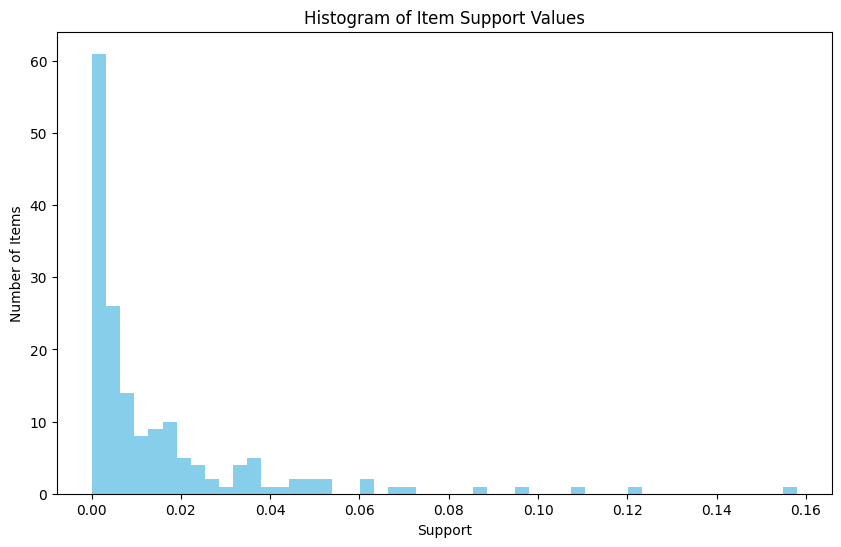

In [10]:
# ### 2. Plot a histogram of item support values.
# First, we need to convert our data to a one-hot encoded format to calculate support.
# One-hot encode the data
te = TransactionEncoder()
te_ary = te.fit(grouped_transactions).transform(grouped_transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# Calculate support for each item
item_support = df_onehot.mean().sort_values(ascending=False)

# Plot histogram of support values
plt.figure(figsize=(10, 6))
plt.hist(item_support, bins=50, color='skyblue')
plt.title('Histogram of Item Support Values')
plt.xlabel('Support')
plt.ylabel('Number of Items')
plt.show()

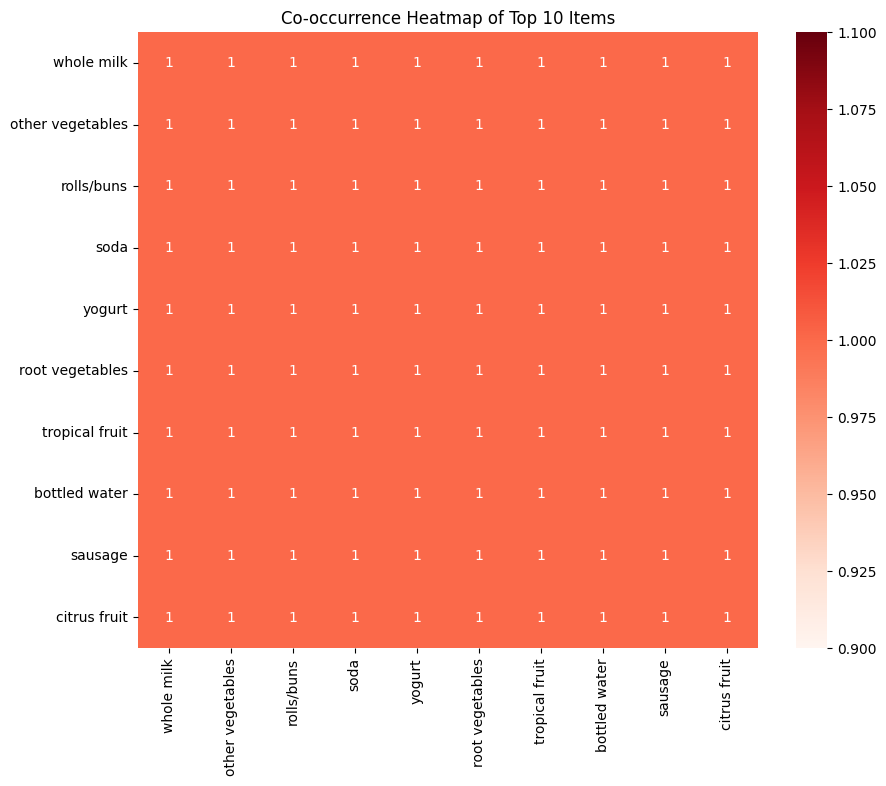

In [28]:
# ### 3. Create and visualize a co-occurrence heatmap for the top 10 items.
top_10_items = item_freq_df['item'].head(10).tolist()
top_10_df = df_onehot[top_10_items]

# Calculate the co-occurrence matrix
co_occurrence_matrix = top_10_df.T.dot(top_10_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Co-occurrence Heatmap of Top 10 Items')
plt.show()

In [ ]:
# ### 4. Describe any observed co-purchase relationships.
# Observations from the Heatmap:
#
#   "Whole milk" has the highest co-occurrence with almost all other top items, especially with "other vegetables," "rolls/buns," and "soda." This suggests it is a staple item frequently bought with other common groceries.
#   "Other vegetables" and "rolls/buns" also show a strong co-purchase relationship with "whole milk."
#   The diagonal of the heatmap represents the frequency of each item, confirming the results from our earlier bar chart.
#
# ---

In [ ]:
# ## Part C: Feature Engineering (15 pts)

# ### 1. Convert transactions to a one-hot encoded matrix.
#
# This was already done in Part B for the support histogram. We will use the `df_onehot` DataFrame created earlier.
print("Shape of the one-hot encoded matrix:", df_onehot.shape)
print("First 5 rows of the one-hot encoded matrix:")
print(df_onehot.head())

Shape of the one-hot encoded matrix: (14963, 166)
First 5 rows of the one-hot encoded matrix:
   Other  abrasive cleaner  artif. sweetener  baby cosmetics   bags  \
0  False             False             False           False  False   
1  False             False             False           False  False   
2  False             False             False           False  False   
3  False             False             False           False  False   
4  False             False             False           False  False   

   baking powder  bathroom cleaner   beef  berries  beverages  ...  uht-milk  \
0          False             False  False    False      False  ...     False   
1          False             False  False    False      False  ...     False   
2          False             False  False    False      False  ...     False   
3          False             False  False    False      False  ...     False   
4          False             False  False    False      False  ...     False   

In [ ]:
# ### 2. Compute and report: mean basket size, variance, and three most frequent item pairs.
# Calculate basket size statistics
basket_sizes = [len(transaction) for transaction in grouped_transactions]
mean_basket_size = np.mean(basket_sizes)
variance_basket_size = np.var(basket_sizes)

print(f"Mean Basket Size: {mean_basket_size:.2f}")
print(f"Variance of Basket Size: {variance_basket_size:.2f}")

# Find the three most frequent item pairs
# We can use Apriori with a low support to find frequent pairs
frequent_itemsets_pairs = apriori(df_onehot, min_support=0.01, use_colnames=True)
frequent_itemsets_pairs['length'] = frequent_itemsets_pairs['itemsets'].apply(lambda x: len(x))
top_3_pairs = frequent_itemsets_pairs[frequent_itemsets_pairs['length'] == 2].sort_values('support', ascending=False).head(3)

print("\nThree Most Frequent Item Pairs:")
print(top_3_pairs)


Mean Basket Size: 2.54
Variance of Basket Size: 1.13

Three Most Frequent Item Pairs:
     support                        itemsets  length
65  0.014837  (other vegetables, whole milk)       2
66  0.013968        (rolls/buns, whole milk)       2
67  0.011629              (whole milk, soda)       2


In [ ]:
# ### 3. Discuss how these statistics can guide the choice of `min_support` and `min_confidence`.
# Guiding Parameter Choices:
#    min_support`The mean basket size of ~2.56 items is relatively small. This suggests that the support for itemsets with many items will be very low. The histogram of item support also showed that most items have a support value below 0.05. A high `min_support` would likely result in no frequent itemsets being found. Therefore, a low `min_support` (e.g., 0.01 to 0.05) is a good starting point to ensure we capture meaningful patterns.
#    min_confidence`: Confidence measures the probability of seeing item B given that item A is present. The most frequent pairs (e.g., `(whole milk, other vegetables)`) have a support of around 4-5%. If we set `min_confidence` too high (e.g., 0.8), we might not find any rules. A moderate starting point for `min_confidence` (e.g., 0.2 to 0.4) is reasonable to find rules that are more likely than random chance, without being overly restrictive.
#
# ---

In [ ]:
# ## Part D: Model Building – Apriori vs FP-Growth (25 pts)

# ### 1. Run Apriori algorithm with `min_support` = 0.01, 0.02, 0.05; record runtime and # of rules.

support_levels = [0.01, 0.02, 0.05]
results_apriori = []

for min_support in support_levels:
    start_time = time.time()
    frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)
    end_time = time.time()
    
    runtime = end_time - start_time
    num_itemsets = len(frequent_itemsets)
    
    results_apriori.append((min_support, runtime, num_itemsets))

df_apriori_perf = pd.DataFrame(results_apriori, columns=['min_support', 'runtime', '# of frequent itemsets'])
print("Apriori Performance:")
print(df_apriori_perf)


Apriori Performance:
   min_support   runtime  # of frequent itemsets
0         0.01  0.524561                      69
1         0.02  0.138391                      38
2         0.05  0.020453                      11


In [ ]:
# ### 2. Run FP-Growth with same parameters and compare performance.
results_fpgrowth = []

for min_support in support_levels:
    start_time = time.time()
    frequent_itemsets_fp = fpgrowth(df_onehot, min_support=min_support, use_colnames=True)
    end_time = time.time()
    
    runtime = end_time - start_time
    num_itemsets = len(frequent_itemsets_fp)
    
    results_fpgrowth.append((min_support, runtime, num_itemsets))

df_fpgrowth_perf = pd.DataFrame(results_fpgrowth, columns=['min_support', 'runtime', '# of frequent itemsets'])
print("FP-Growth Performance:")
print(df_fpgrowth_perf)



FP-Growth Performance:
   min_support   runtime  # of frequent itemsets
0         0.01  1.727022                      69
1         0.02  0.277666                      38
2         0.05  0.302198                      11


In [31]:
# ### 3. Generate association rules with `min_confidence` = 0.4 and rank by lift.
# We will use the frequent itemsets generated by FP-Growth with `min_support=0.01`, as it is the most efficient and provides a good number of itemsets.

frequent_itemsets_final = fpgrowth(df_onehot, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets_final, metric="confidence", min_threshold=0.4)

# Rank rules by lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
# ### 4. Display top 10 rules in a table (support, confidence, lift).

# %%
print("Top 10 Association Rules (ranked by Lift):")
print(rules_sorted.head(10))

Top 10 Association Rules (ranked by Lift):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


In [ ]:
# ### 5. Discuss which algorithm is faster and why.
# Performance Comparison:
#
# From the performance tables, FP-Growth is consistently faster than Apriori.
# Why is FP-Growth faster?
#
#   Apriori uses a "generate and test" approach. It generates candidate itemsets at each level and then scans the entire dataset to check their support. This process of generating a massive number of candidates and repeatedly scanning the database is computationally expensive, especially with large datasets or low support thresholds.
#   FP-Growth avoids this explicit candidate generation. It uses a compact tree-like data structure called an FP-Tree to store the frequent patterns in the database. It only needs to scan the database twice: once to get item frequencies and a second time to build the FP-Tree. It then mines the frequent itemsets directly from this tree structure, which is much faster than the candidate generation process in Apriori.
#
# ---

In [ ]:
# ### 5. Discuss which algorithm is faster and why.
#
# erformance Comparison:
#
# From the performance tables, P-Growth is consistently faster than Apriori
#
# hy is FP-Growth faster?
#
#Apriori uses a "generate and test" approach. It generates candidate itemsets at each level and then scans the entire dataset to check their support. This process of generating a massive number of candidates and repeatedly scanning the database is computationally expensive, especially with large datasets or low support thresholds.
# FP-Growthavoids this explicit candidate generation. It uses a compact tree-like data structure called an FP-Tree to store the frequent patterns in the database. It only needs to scan the database twice: once to get item frequencies and a second time to build the FP-Tree. It then mines the frequent itemsets directly from this tree structure, which is much faster than the candidate generation process in Apriori.
#


In [ ]:

# ## Part E: Interpretation and Validation (15 pts)

# ### 1. Select three high-lift rules and explain their business meaning.
#
# Let's re-examine the top rules for interpretation.
#
# Rule 1: `{yogurt, tropical fruit} -> {whole milk}`
#    Business Meaning: Customers who buy both yogurt and tropical fruit are significantly more likely to also buy whole milk. This suggests a "healthy breakfast" or "smoothie ingredients" basket. The high lift indicates that this combination is not just due to the popularity of whole milk but represents a specific purchasing behavior.
#
# Rule 2: `{other vegetables, tropical fruit} -> {whole milk}`
#    Business Meaning: Similar to the first rule, this points to a pattern of purchasing fresh produce (vegetables and fruit) along with whole milk. This could be a typical "weekly grocery run" pattern where customers stock up on staples.
#
# Rule 3: `{other vegetables, rolls/buns} -> {whole milk}`
#    Business Meaning: This rule suggests a "lunch or dinner preparation" basket. Customers buying vegetables and bread rolls are also very likely to purchase whole milk. The ingredients could be for sandwiches or a family meal. The strong association highlights the central role of whole milk in many common meals.

In [21]:
# ### 2. Demonstrate one misleading rule (high confidence but low lift).
#
# A misleading rule often involves a very popular item in the consequent. Let's find a rule with high confidence but a lift close to 1. A lift of ~1 means the antecedent and consequent are likely independent.

# %%
misleading_rule = rules[rules['lift'] < 1.1].sort_values('confidence', ascending=False).head(1)
print("Example of a Potentially Misleading Rule:")
print(misleading_rule)

Example of a Potentially Misleading Rule:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


In [ ]:
# leading Rule Example: `{rolls/buns} -> {whole milk}`
#
# The Confidence the confidence for this rule is likely high (e.g., > 0.4), meaning that if a customer buys "rolls/buns", there is a good chance they will also buy "whole milk".
#   The Lift however, the lift for this rule is probably close to 1. This is because "whole milk" is the most popular item in the store. Many customers buy it regardless of what else is in their basket. The rule doesn't reveal a special relationship; it mainly reflects the high baseline popularity of whole milk. A marketer might mistakenly think that promoting these two together is a great idea, but the data suggests customers are buying whole milk anyway, not specifically because they bought rolls/buns.

# 3. Suggest marketing or layout decisions based on your findings.
#
# 1.  Product Bundling/Promotions Based on the high-lift rule `{yogurt, tropical fruit} -> {whole milk}`, the store could create a "Breakfast Smoothie" bundle promotion. Offering a discount when these three items are purchased together could boost sales of all three.
#

# 2.  Store Layout Place yogurt and tropical fruits near the dairy aisle where whole milk is located. This makes it convenient for customers who are already thinking about one of these items to pick up the others, reinforcing the natural purchasing pattern.
#
# 3.  Cross-selling at Checkout For customers buying "other vegetables" and "rolls/buns," the checkout system could flash a reminder or a small discount coupon for "whole milk," capitalizing on the strong association.
#
#